In [2]:
from joblib import Parallel, delayed
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)

<module 'utils' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\utils.py'>

In [54]:
PORTFOLIO = list(_C.commodities.keys())

In [95]:
PORTFOLIO = ['rb', 'hc', 'i', 'm', 'bu', 'SA']

### Pnl

In [68]:
Pnl = {}
total_d_gain = pd.Series([])
total_d_gain = total_d_gain.reindex(_C.BACKTEST_VTD).fillna(0)

In [69]:
for com in _C.commodities.keys():
    com_balance= pd.read_csv(f'output/balance_sheet/{com}_balance.csv')
    com_balance = com_balance.set_index(com_balance.columns[0])
    Pnl[com] = com_balance['Pnl']
    if com in PORTFOLIO:
        total_d_gain += com_balance['d_gain']

Pnl['portfolio'] = 1 + total_d_gain.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)

In [58]:
def draw_pnl(scom):
    fig, axes = plt.subplots(figsize=(10, 5), dpi=80)
    plt.title(f'{scom} Pnl')
    Pnl[scom].plot()

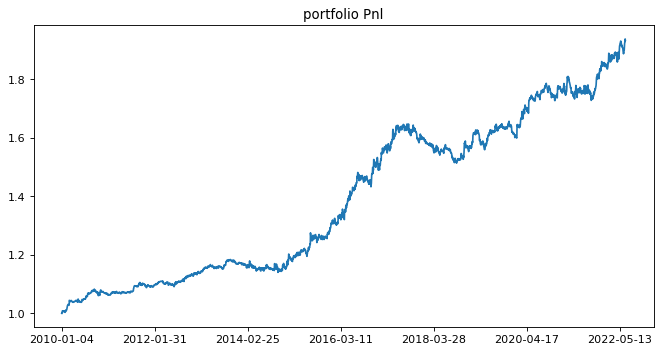

In [70]:
draw_pnl('portfolio')

In [71]:
with open('./output/version/v1/Pnl.pkl', 'wb') as f:
    pickle.dump(Pnl, f)

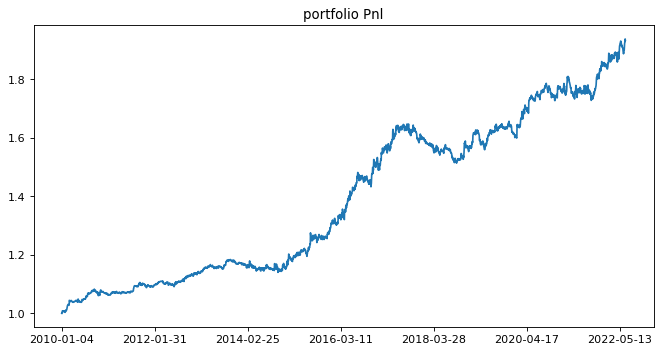

In [73]:
draw_pnl('portfolio')

### Win-Loss

In [96]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

In [97]:
for com in _C.commodities.keys():
    com_log = np.load(f'output/trading_logs/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

    if com in PORTFOLIO:
        all_buy = all_buy.append(com_log[0])
        all_sell = all_sell.append(com_log[1])
        all_total = all_total.append(com_log[2])

trading_logs['portfolio'] = [all_buy, all_sell, all_total]

In [98]:
def cal_win_rate(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].shape[0] / _df_['gain'].shape[0], 4)

def cal_win_loss_ratio(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].sum() / _df_['gain'].loc[_df_['gain']<0].sum() * -1, 4)

In [99]:
cols = ['BUY_wr', 'SELL_wr', 'TOTAL_wr', 'BUY_wlr', 'SELL_wlr', 'TOTAL_wlr']
symbols = list(_C.commodities.keys())+['portfolio']

In [100]:
Win_Loss_Analysis = pd.DataFrame(columns=symbols)
WLA = Win_Loss_Analysis.reindex(cols).transpose()

In [101]:
for com in symbols:
    buy_log = trading_logs[com][0]
    sell_log= trading_logs[com][1]
    total_log = trading_logs[com][2]

    WLA['BUY_wr'][com] = cal_win_rate(buy_log)
    WLA['SELL_wr'][com] = cal_win_rate(sell_log)
    WLA['TOTAL_wr'][com] = cal_win_rate(total_log)

    WLA['BUY_wlr'][com] = cal_win_loss_ratio(buy_log)
    WLA['SELL_wlr'][com] = cal_win_loss_ratio(sell_log)
    WLA['TOTAL_wlr'][com] = cal_win_loss_ratio(total_log)

In [102]:
WLA

,BUY_wr,SELL_wr,TOTAL_wr,BUY_wlr,SELL_wlr,TOTAL_wlr
rb,0.3064,0.2913,0.2987,1.1658,1.0762,1.1178
hc,0.321,0.2849,0.3022,1.1838,1.0583,1.1172
i,0.3087,0.2927,0.3004,1.1162,1.2043,1.163
m,0.3146,0.2824,0.2989,1.1541,1.0701,1.1108
pp,0.2871,0.2981,0.2926,0.9463,1.1066,1.026
MA,0.2933,0.2676,0.2803,1.0813,0.9323,1.002
bu,0.2879,0.2971,0.2925,1.0741,1.1125,1.0935
l,0.3021,0.2795,0.2909,1.0126,0.9981,1.0056
p,0.3011,0.2677,0.2889,1.1287,1.0056,1.093
v,0.2795,0.276,0.2777,1.0372,0.9985,1.0177


In [103]:
WLA.to_csv('./output/version/v1/Win-Loss.csv')

In [21]:
cc = pd.read_csv('./output/version/v1/Win-Loss.csv', index_col=0)

### Positions

#### Positions Holding Time

In [104]:
hold_t = {}
all_hold_t = []
all_hold_t = pd.Series(all_hold_t)

for com in _C.commodities.keys():
    _df = trading_logs[com][2].copy(deep=True)

    delta_t = pd.to_datetime(_df['close_date']) - pd.to_datetime(_df['open_date'])
    _df['hold_t'] = (delta_t).apply(lambda x: x.total_seconds()/60)

    hold_t[com] = _df['hold_t']
    if com in PORTFOLIO:
        all_hold_t = all_hold_t.append(_df['hold_t'])

hold_t['portfolio'] = all_hold_t

In [105]:
def hold_t_analysis(scom):
    ht = hold_t[scom]
    print(ht.describe())
    ht.hist(bins=20)

In [106]:
cols_2 = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
HTA = pd.DataFrame(columns=symbols)
HTA = HTA.reindex(cols_2).transpose()

In [107]:
for com in symbols:
    ht = hold_t[com]
    des = list(ht.describe())
    for i in cols_2:
        HTA[i][com] = round(int(des[cols_2.index(i)])/60, 1) if cols_2.index(i)>0 else des[cols_2.index(i)]

In [108]:
HTA # Holding Period Time

,count,mean,std,min,25%,50%,75%,max
rb,2501,24.1,42.4,0,0,0,24,456
hc,2088,18.8,35.9,0,0,0,24,456
i,1801,19.6,33.9,0,0,0,24,312
m,2650,25,44.5,0,0,0,24,432
pp,1661,23.7,43.3,0,0,0,24,432
MA,1944,18.9,35.3,0,0,0,24,264
bu,2092,21.5,38.3,0,0,0,24,456
l,2166,28,50.3,0,0,0,24,528
p,2385,22.7,43.3,0,0,0,24,504
v,2391,26,46.4,0,0,0,24,624


In [109]:
HTA.to_csv('./output/version/v1/HTA.csv')

#### Daily Trade Num

In [110]:
trade_num = {}
all_trade_num = pd.Series([0 for i in range(len(_C.BACKTEST_VTD))])

for com in _C.commodities.keys():
    tn = [0 for i in range(len(_C.BACKTEST_VTD))]
    com_log = trading_logs[com]
    _df = com_log[2].copy(deep=True)

    for i in range(_df.shape[0]):
        entry = _df.iloc[i]
        tn[_C.BACKTEST_VTD.index(entry['open_date'])] += 1
        tn[_C.BACKTEST_VTD.index(entry['close_date'])] += 1
    
    trade_num[com] = tn
    if com in PORTFOLIO:
        all_trade_num += pd.Series(tn)

trade_num['portfolio'] = all_trade_num.to_list()

In [111]:
DTN = pd.DataFrame()
DTN = DTN.reindex(_C.BACKTEST_VTD)

for com in symbols:
    DTN[com] = trade_num[com]

In [112]:
DTN # Daily Trade Num

,rb,hc,i,m,pp,MA,bu,l,p,v,CF,OI,SR,TA,SA,portfolio
2010-01-04,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2010-01-05,1,0,0,0,0,0,0,0,0,3,1,0,4,2,0,1
2010-01-06,3,0,0,0,0,0,0,4,0,3,1,0,3,0,0,3
2010-01-07,3,0,0,1,0,0,0,4,1,2,2,0,3,2,0,4
2010-01-08,3,0,0,1,0,0,0,0,1,2,4,0,3,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20,1,0,2,2,0,2,1,2,1,0,3,2,2,6,4,10
2022-06-21,3,1,1,4,4,1,2,1,0,2,0,0,2,3,0,11
2022-06-22,4,2,0,5,3,2,3,0,1,3,1,0,3,5,2,16
2022-06-23,1,1,1,1,4,2,3,0,0,3,1,1,0,4,1,8


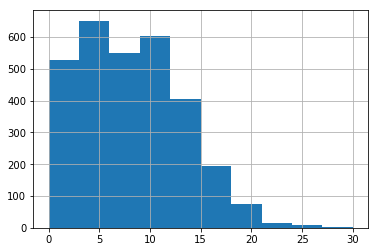

In [114]:
DTN['portfolio'].hist()

In [115]:
DTN.to_csv('./output/version/v1/DTN.csv')

### Version Comparation

In [35]:
Pnl.keys()

dict_keys(['rb', 'hc', 'i', 'm', 'pp', 'MA', 'bu', 'l', 'p', 'v', 'CF', 'OI', 'SR', 'TA', 'SA', 'total'])

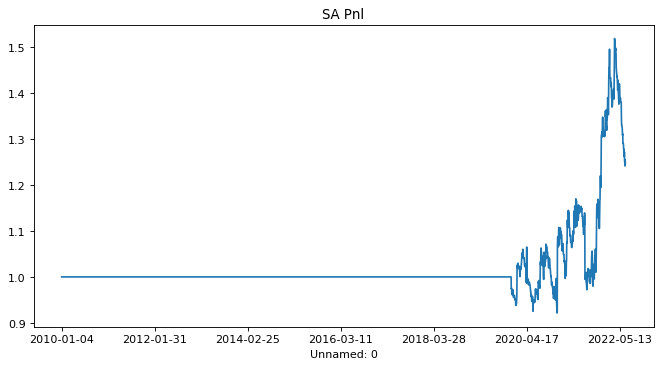

In [50]:
draw_pnl('SA')